In [1]:
import os
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import csv
import gzip
import sys
sys.path.append('/data/yan_code/scDWL/')
import scipy.io
import scipy.sparse as sps
import matplotlib.pyplot as plt
from os.path import join
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize
from metrics import osr_evaluator

from core import BuildscNCL
import utils as utls
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
np.random.seed(1234)
sc.settings.verbosity = 3
sc.logging.print_header()
exp_id = 'CITE-ASAP' + '-1201'  # dataset_name + timestamp

data_root = '/data/yan_code/scNCL-release/data/scNCL_data/'

adata_rna = sc.read_h5ad(join(data_root, 'CITE-ASAP/adata_rna_cache.h5ad'))
adata_atac = sc.read_h5ad(join(data_root, 'CITE-ASAP/adata_atac_cache.h5ad'))

meta_rna = adata_rna.obs
meta_atac = adata_atac.obs

meta = pd.concat([meta_rna, meta_atac], axis=0)
# proteomics data, already lognormalized
adata_cite_adt = sc.AnnData(sps.load_npz(join(data_root, 'CITE-ASAP/citeseq_control_adt.npz')), obs=adata_rna.obs)
adata_asap_adt = sc.AnnData(sps.load_npz(join(data_root, 'CITE-ASAP/asapseq_control_adt.npz')), obs=adata_atac.obs)
atac_raw_emb = adata_asap_adt.X.A
# params dict of preprocessing 
ppd = {'binz': True, 
       'hvg_num':adata_atac.shape[1], 
       'lognorm':False, 
       'scale_per_batch':False,  
       'batch_label': 'domain',
       'type_label':  'cell_type',
       'knn': 10,
       'knn_by_tissue':False
       }  # default settings
#  outputs folder
myoutput_dir = join(f'/data/yan_code/scDWL/outputs/{exp_id}')
os.makedirs(myoutput_dir, exist_ok=True)
model = BuildscNCL(
                n_latent=48, bn=False, dr=0.2, 
                cont_w=0.2, cont_tau=0.8,mycenter_w=0.1,center_cutoff=0,
        )
atac_number_label,label_dict=model.preprocess(
                [adata_rna, adata_atac],   # list of 'anndata' object
                atac_raw_emb,   
                adata_adt_inputs=[adata_cite_adt, adata_asap_adt], # 
                pp_dict = ppd
        )

/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.22.3 scipy==1.8.0 pandas==1.5.3 scikit-learn==1.3.0 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11
Finding highly variable genes...
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/data/yan_code/scDWL/dataset.py:45: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  hvg_total = (hvg_rna) & (hvg_atac)


Concating adt features...
==========************************************================
knn correct ratio = 0.8957
===========**************************************===============


In [2]:
adata_atac

AnnData object with n_obs × n_vars = 4502 × 17441
    obs: 'cell_type', 'data_type'

In [3]:
adata_rna

AnnData object with n_obs × n_vars = 4644 × 17441
    obs: 'cell_type', 'data_type'

In [6]:
if 1:
    model.train(
        batch_size=512, training_steps=5000, 
        lr=0.01, 
        log_step=50, eval_atac=True, output_dir=myoutput_dir,eval_top_k=2, eval_open=True,  
    )
else:
    # loading checkpoints
        ckpt_path = join(myoutput_dir, 'ckpt_cite.pth')
        model.load_ckpt(ckpt_path)

step 0, loss_cls=1.926, loss_l1_reg=0.143, center=(0.017, 0.024), corr=(0.000, 0.000), var=(0.904, 0.569), loss_cont=2.755, loss_align=0.000, loss_mycenter=0.000
close_acc= 0.2550
AUROC= 0.6525
AUPR= 0.1955
OSCR= 0.1722
step 50, loss_cls=0.219, loss_l1_reg=0.144, center=(0.054, 0.053), corr=(0.007, 0.007), var=(0.205, 0.191), loss_cont=2.456, loss_align=0.000, loss_mycenter=0.289
close_acc= 0.9264
AUROC= 0.8068
AUPR= 0.3570
OSCR= 0.7694
step 100, loss_cls=0.110, loss_l1_reg=0.141, center=(0.050, 0.054), corr=(0.006, 0.007), var=(0.223, 0.186), loss_cont=2.439, loss_align=0.000, loss_mycenter=0.189
close_acc= 0.9358
AUROC= 0.7592
AUPR= 0.3141
OSCR= 0.7306
step 150, loss_cls=0.064, loss_l1_reg=0.140, center=(0.048, 0.056), corr=(0.005, 0.007), var=(0.233, 0.180), loss_cont=2.422, loss_align=0.000, loss_mycenter=0.146
close_acc= 0.9343
AUROC= 0.7683
AUPR= 0.3169
OSCR= 0.7401
step 200, loss_cls=0.047, loss_l1_reg=0.139, center=(0.046, 0.057), corr=(0.005, 0.008), var=(0.240, 0.175), loss_c

KeyboardInterrupt: 

In [14]:
ckpt_path = join("/data/yan_code/scDWL/outputs/CITE-ASAP-1201/0.9357709886937695.pth")
model.load_ckpt(ckpt_path)

loaded checkpoints from /data/yan_code/scDWL/outputs/CITE-ASAP-1201/0.9357709886937695.pth


In [15]:
model.eval(inplace=True)
atac_pred_type= model.annotate()
ad_atac = sc.AnnData(model.feat_B)
ad_atac.obs = meta_atac.copy()
ad_atac.obs['pred_type'] = atac_pred_type
ad_atac.obs['pred_conf'] = np.max(model.head_B, axis=1)
#计算准确率
true_label = ad_atac.obs['cell_type']
pred_label = ad_atac.obs['pred_type']
from sklearn.metrics import accuracy_score
accuracy_score(true_label, pred_label)


0.8640604175921812

Finding highly variable genes...
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/data/yan_code/scDWL/dataset.py:45: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  hvg_total = (hvg_rna) & (hvg_atac)


normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


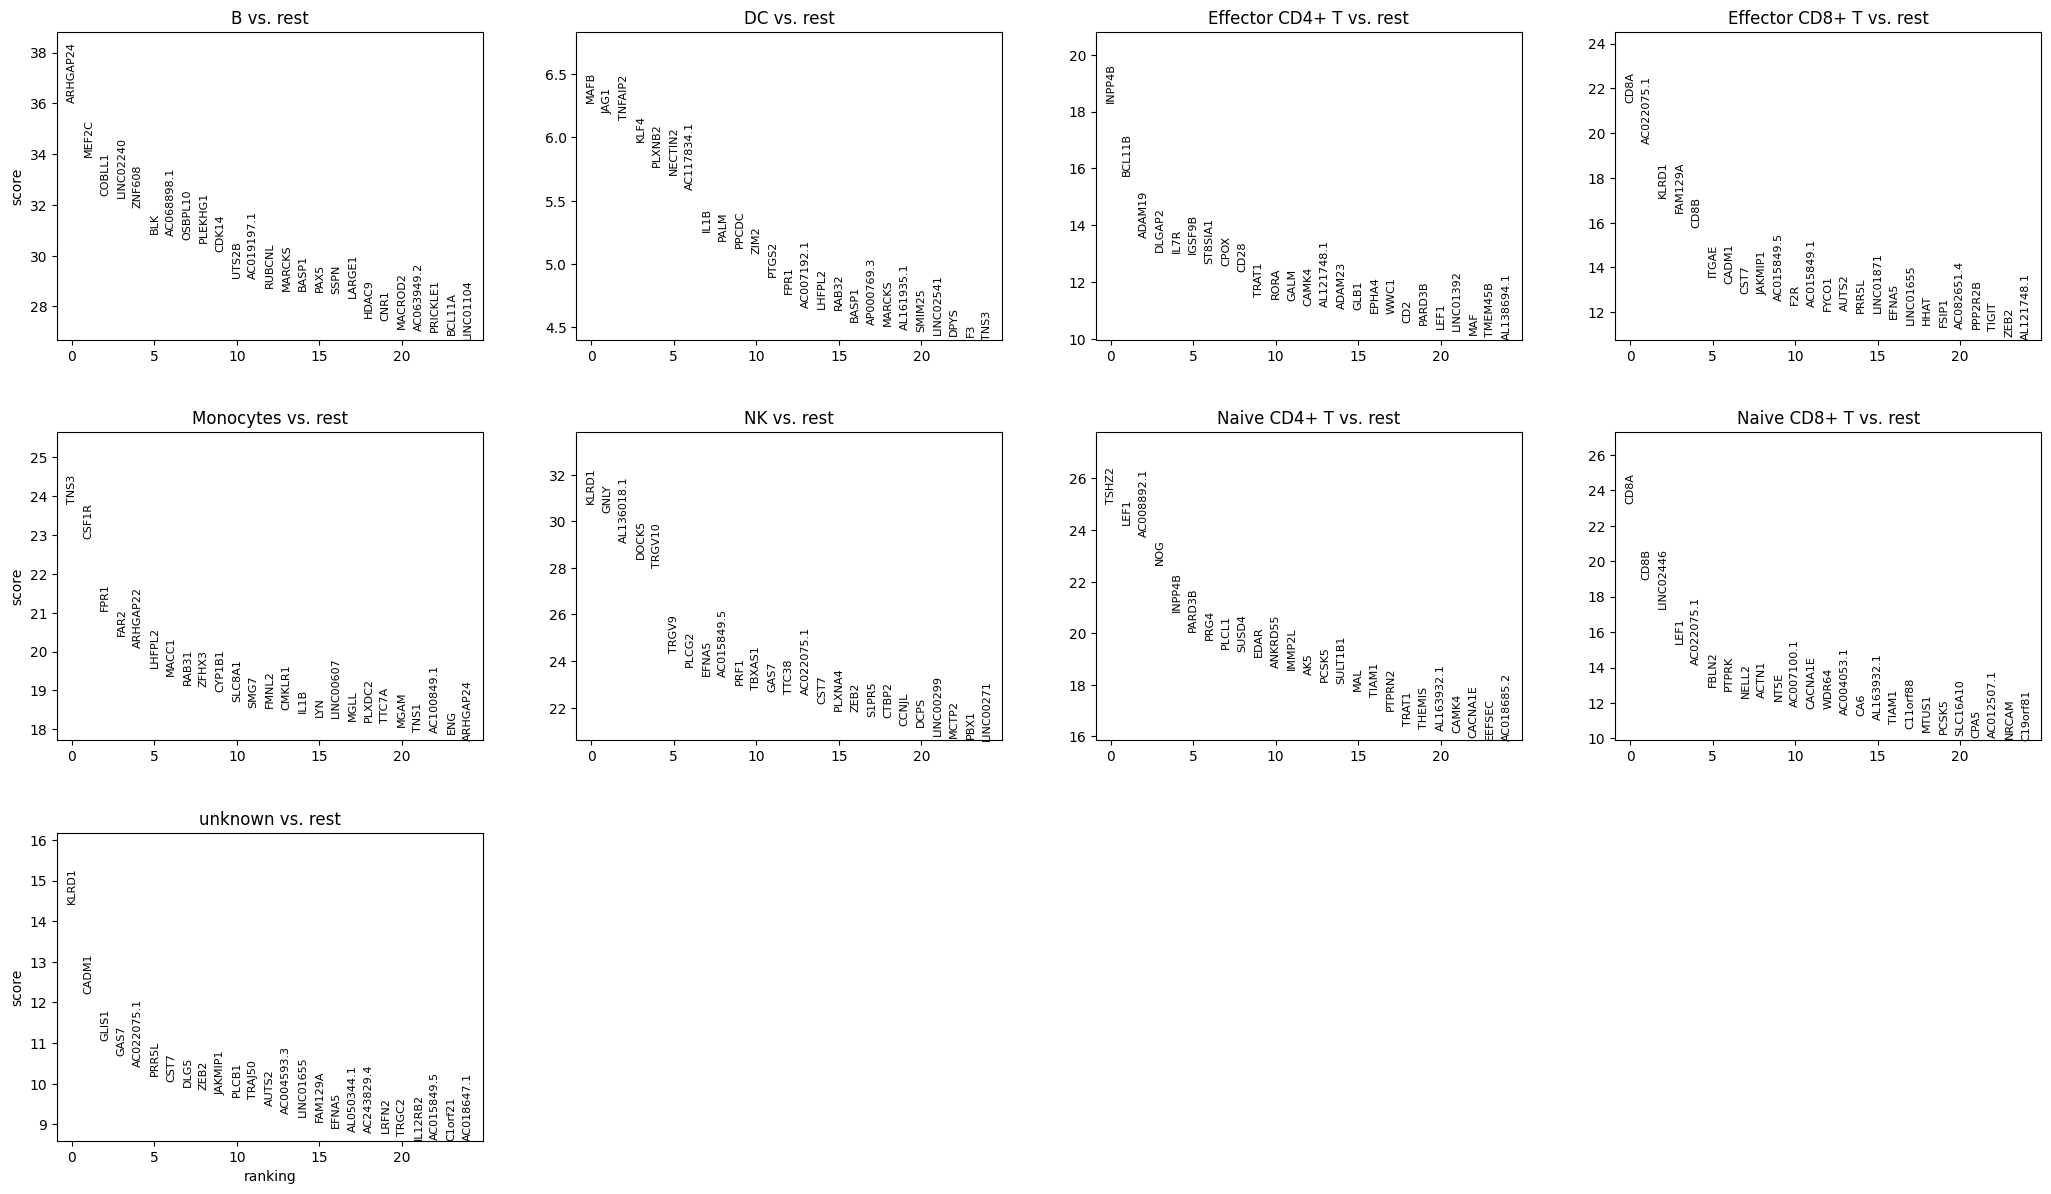

Cell type: B
['ARHGAP24' 'MEF2C' 'COBLL1' 'LINC02240' 'ZNF608' 'BLK' 'AC068898.1'
 'OSBPL10' 'PLEKHG1' 'CDK14' 'UTS2B' 'AC019197.1' 'RUBCNL' 'MARCKS'
 'BASP1' 'PAX5' 'SSPN' 'LARGE1' 'HDAC9' 'CNR1']
Cell type: DC
['MAFB' 'JAG1' 'TNFAIP2' 'KLF4' 'PLXNB2' 'NECTIN2' 'AC117834.1' 'IL1B'
 'PALM' 'PPCDC' 'ZIM2' 'PTGS2' 'FPR1' 'AC007192.1' 'LHFPL2' 'RAB32'
 'BASP1' 'AP000769.3' 'MARCKS' 'AL161935.1']
Cell type: Effector CD4+ T
['INPP4B' 'BCL11B' 'ADAM19' 'DLGAP2' 'IL7R' 'IGSF9B' 'ST8SIA1' 'CPOX'
 'CD28' 'TRAT1' 'RORA' 'GALM' 'CAMK4' 'AL121748.1' 'ADAM23' 'GLB1' 'EPHA4'
 'WWC1' 'CD2' 'PARD3B']
Cell type: Effector CD8+ T
['CD8A' 'AC022075.1' 'KLRD1' 'FAM129A' 'CD8B' 'ITGAE' 'CADM1' 'CST7'
 'JAKMIP1' 'AC015849.5' 'F2R' 'AC015849.1' 'FYCO1' 'AUTS2' 'PRR5L'
 'LINC01871' 'EFNA5' 'LINC01655' 'HHAT' 'FSIP1']
Cell type: Monocytes
['TNS3' 'CSF1R' 'FPR1' 'FAR2' 'ARHGAP22' 'LHFPL2' 'MACC1' 'RAB31' 'ZFHX3'
 'CYP1B1' 'SLC8A1' 'SMG7' 'FMNL2' 'CMKLR1' 'IL1B' 'LYN' 'LINC00607' 'MGLL'
 'PLXDC2' 'TTC7A']
Cell ty

In [26]:
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from dataset import ClsDataset, hvg_binz_lognorm_scale
import torch.utils.data.dataloader as dataloader
class CombinedModel(nn.Module):
    def __init__(self, encoder, cell):
        super(CombinedModel, self).__init__()
        self.encoder = encoder
        self.cell = cell
    def forward(self, x):
        embedding, attention = self.encoder(x)
        output = self.cell(embedding)
        output=nn.Softmax(dim=1)(output)
        return output
new_model = CombinedModel(model.encoder, model.head)
new_model.eval()
rna, atac, hvg_total = hvg_binz_lognorm_scale(adata_rna, adata_atac, ppd['hvg_num'], ppd['binz'], 
                                            ppd['lognorm'], ppd['scale_per_batch']) #获取高表达基因,并且log1p
queydata = sps.csr_matrix(atac.X)#查询数据集
tgt_ds = ClsDataset(queydata, atac_number_label, binz=False, train=False)
tgt_dl = dataloader.DataLoader(tgt_ds, batch_size=512, shuffle=False, num_workers=3, drop_last=False)
reversed_dict = {value: key for key, value in label_dict.items()}
adata=atac.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# 进行差异表达分析
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
# 查看差异表达基因
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# 提取差异表达基因信息
# 这里我们提取每个细胞类型的前10个差异表达基因
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
de_genes = {group: result['names'][group][:20] for group in groups}

for group, genes in de_genes.items():
    print(f"Cell type: {group}")
    print(genes)

In [17]:
atac_my=sc.AnnData(model.feat_B, obs=meta_atac)
atac_my=utls.umap_for_adata(atac_my)


/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


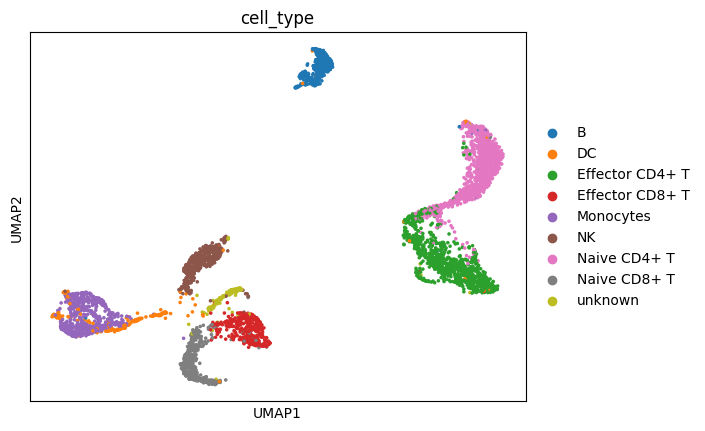

In [18]:

sc.pl.umap(atac_my, color=['cell_type'],save='CellpredX_true_cell_type_CITE.png')

/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


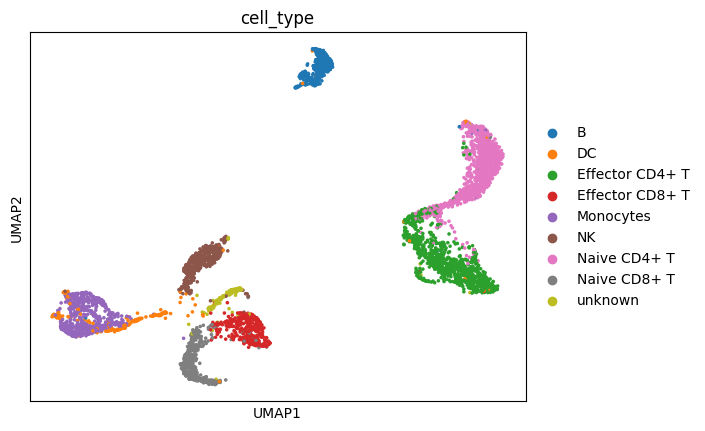

/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


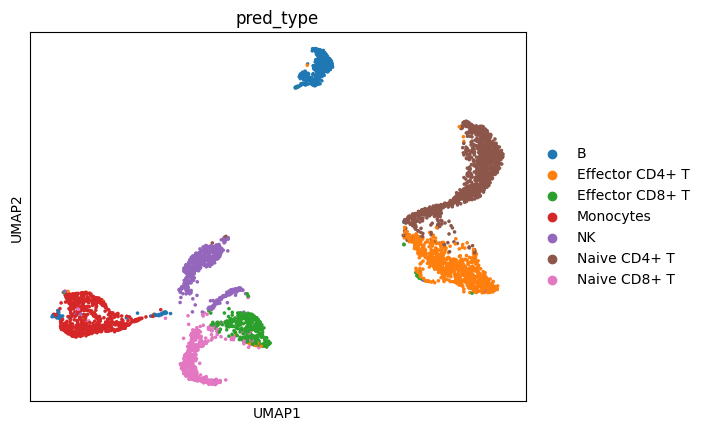

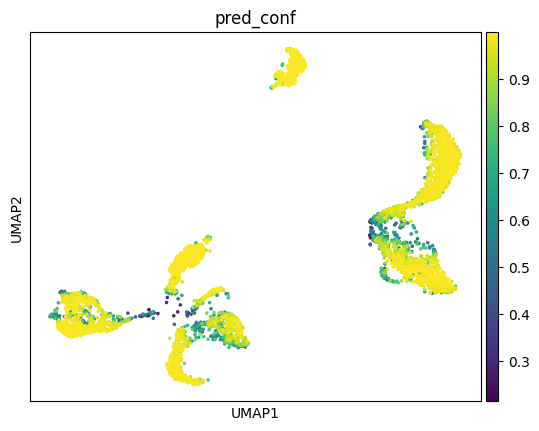

In [19]:
ad_atac = utls.umap_for_adata(ad_atac)
sc.pl.umap(ad_atac, color=['cell_type'],save='CellpredX_true_cell_type_CITE_atac.png')
sc.pl.umap(ad_atac, color=['pred_type'],save='CellpredX_pred_cell_type_CITE_atac.png')
sc.pl.umap(ad_atac, color=['pred_conf'],save='CellpredX_pred_confidence_CITE_atac.png')

/home/liuyan/anaconda3/envs/scncl/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


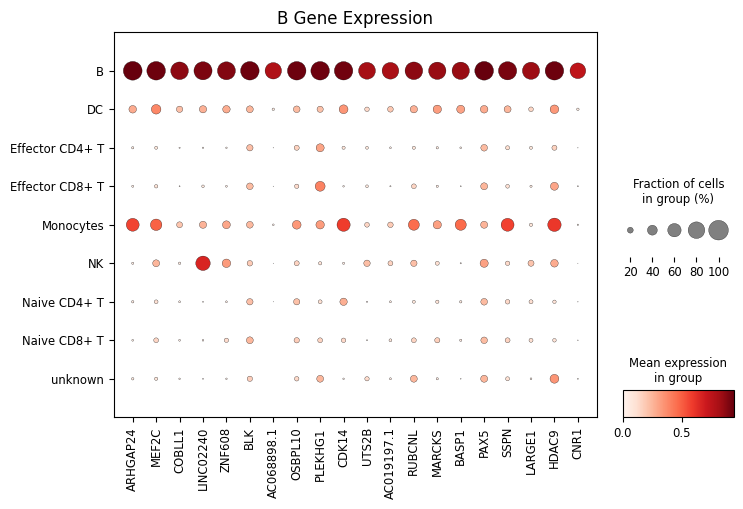

AttributeError: 'NoneType' object has no attribute 'legend'

In [46]:
import scanpy as sc

# Create the gene dictionary with cell types and their corresponding genes
genes_dict = {
    'B': ['ARHGAP24', 'MEF2C', 'COBLL1', 'LINC02240', 'ZNF608', 'BLK', 'AC068898.1', 'OSBPL10', 'PLEKHG1', 'CDK14', 'UTS2B', 'AC019197.1', 'RUBCNL', 'MARCKS', 'BASP1', 'PAX5', 'SSPN', 'LARGE1', 'HDAC9', 'CNR1'],
    'DC': ['MAFB', 'JAG1', 'TNFAIP2', 'KLF4', 'PLXNB2', 'NECTIN2', 'AC117834.1', 'IL1B', 'PALM', 'PPCDC', 'ZIM2', 'PTGS2', 'FPR1', 'AC007192.1', 'LHFPL2', 'RAB32', 'BASP1', 'AP000769.3', 'MARCKS', 'AL161935.1'],
    'Effector CD4+ T': ['INPP4B', 'BCL11B', 'ADAM19', 'DLGAP2', 'IL7R', 'IGSF9B', 'ST8SIA1', 'CPOX', 'CD28', 'TRAT1', 'RORA', 'GALM', 'CAMK4', 'AL121748.1', 'ADAM23', 'GLB1', 'EPHA4', 'WWC1', 'CD2', 'PARD3B'],
    'Effector CD8+ T': ['CD8A', 'AC022075.1', 'KLRD1', 'FAM129A', 'CD8B', 'ITGAE', 'CADM1', 'CST7', 'JAKMIP1', 'AC015849.5', 'F2R', 'AC015849.1', 'FYCO1', 'AUTS2', 'PRR5L', 'LINC01871', 'EFNA5', 'LINC01655', 'HHAT', 'FSIP1'],
    'Monocytes': ['TNS3', 'CSF1R', 'FPR1', 'FAR2', 'ARHGAP22', 'LHFPL2', 'MACC1', 'RAB31', 'ZFHX3', 'CYP1B1', 'SLC8A1', 'SMG7', 'FMNL2', 'CMKLR1', 'IL1B', 'LYN', 'LINC00607', 'MGLL', 'PLXDC2', 'TTC7A'],
    'NK': ['KLRD1', 'GNLY', 'AL136018.1', 'DOCK5', 'TRGV10', 'TRGV9', 'PLCG2', 'EFNA5', 'AC015849.5', 'PRF1', 'TBXAS1', 'GAS7', 'TTC38', 'AC022075.1', 'CST7', 'PLXNA4', 'ZEB2', 'S1PR5', 'CTBP2', 'CCNJL'],
    'Naive CD4+ T': ['TSHZ2', 'LEF1', 'AC008892.1', 'NOG', 'INPP4B', 'PARD3B', 'PRG4', 'PLCL1', 'SUSD4', 'EDAR', 'ANKRD55', 'IMMP2L', 'AK5', 'PCSK5', 'SULT1B1', 'MAL', 'TIAM1', 'PTPRN2', 'TRAT1', 'THEMIS'],
    'Naive CD8+ T': ['CD8A', 'CD8B', 'LINC02446', 'LEF1', 'AC022075.1', 'FBLN2', 'PTPRK', 'NELL2', 'ACTN1', 'NT5E', 'AC007100.1', 'CACNA1E', 'WDR64', 'AC004053.1', 'CA6', 'AL163932.1', 'TIAM1', 'C11orf88', 'MTUS1', 'PCSK5'],
    'unknown': ['KLRD1', 'CADM1', 'GLIS1', 'GAS7', 'AC022075.1', 'PRR5L', 'CST7', 'DLG5', 'ZEB2', 'JAKMIP1', 'PLCB1', 'TRAJ50', 'AUTS2', 'AC004593.3', 'LINC01655', 'FAM129A', 'EFNA5', 'AL050344.1', 'AC243829.4', 'LRFN2']
}

# Visualize gene expression for each cell type
for cell_type, genes in genes_dict.items():
    dotplot=sc.pl.dotplot(adata_atac, genes, groupby='cell_type', use_raw=False, title=f'{cell_type} Gene Expression',figsize=(8,5), dendrogram=False)
    dotplot.legend(colorbar_title='log(UMI counts + 1)').show()

    #sc.pl.matrixplot(adata_atac, genes, groupby='cell_type', use_raw=False, title=f'{cell_type} Gene Expression', dendrogram=False)



In [20]:
ad_atac.obs['pred_type']
share_mask = meta_atac.cell_type.isin(meta_rna.cell_type.unique()).to_numpy()
open_score = 1 - np.max(model.head_B, axis=1) # pb_max, logit_max_B

kn_data_pr = atac_pred_type[share_mask]
kn_data_gt = meta_atac.cell_type[share_mask].to_numpy()
kn_data_open_score = open_score[share_mask]

unk_data_open_score = open_score[np.logical_not(share_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)

close_acc= 0.9358
AUROC= 0.7561
AUPR= 0.2798
OSCR= 0.7336


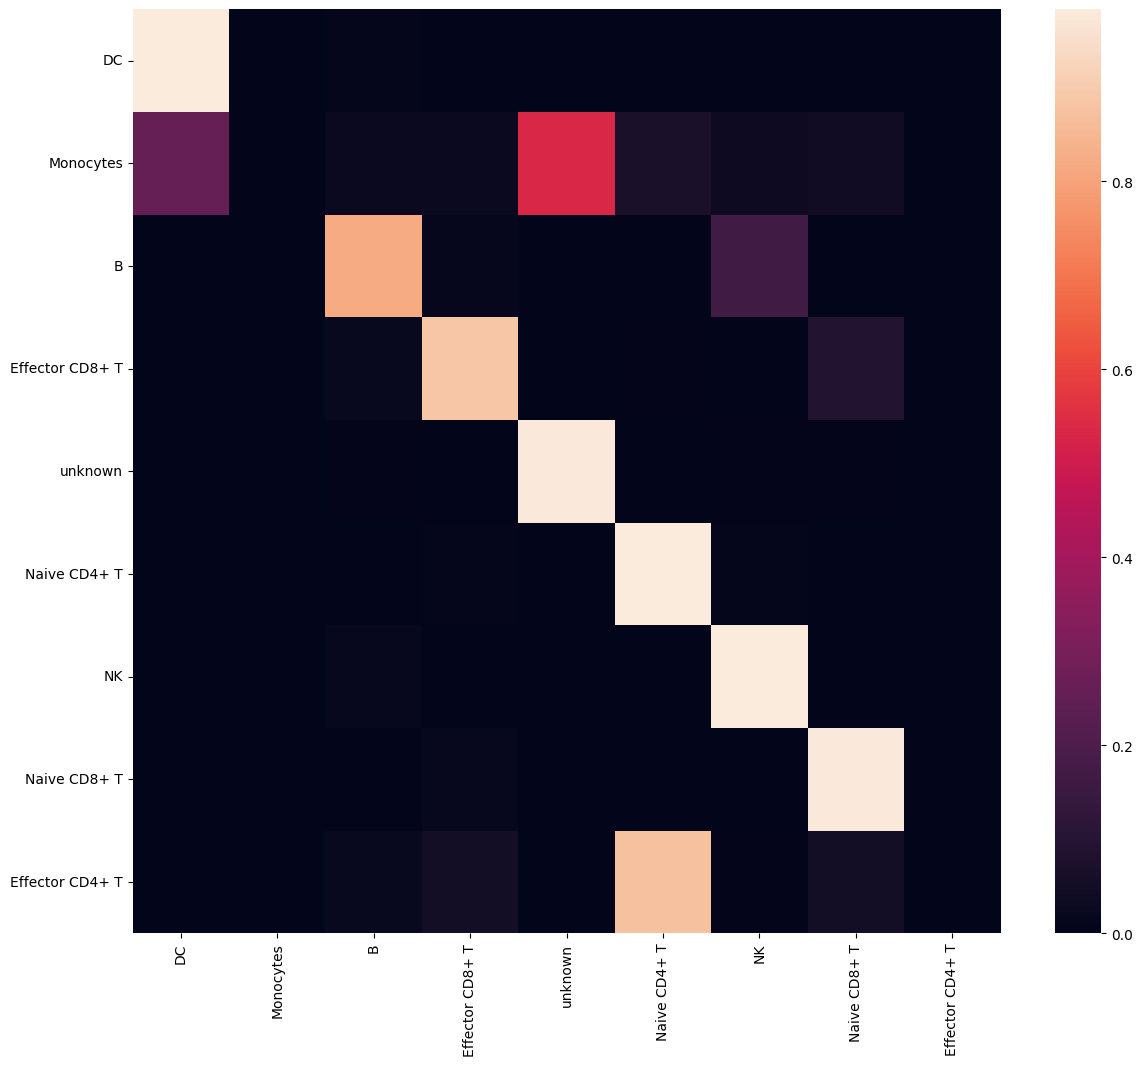

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(meta_atac.cell_type.to_numpy(), atac_pred_type)
cm = cm/cm.sum(axis=1, keepdims=True)

df_cm = pd.DataFrame(cm, index = meta_atac.cell_type.unique(),
                  columns = meta_atac.cell_type.unique())

plt.figure(figsize = (14,12))
sns.heatmap(df_cm, )
plt.savefig('./figures/CellpredX_confusion_matrix_CITE.png',dpi=300)